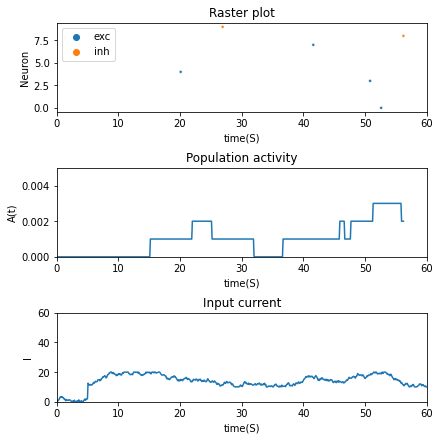

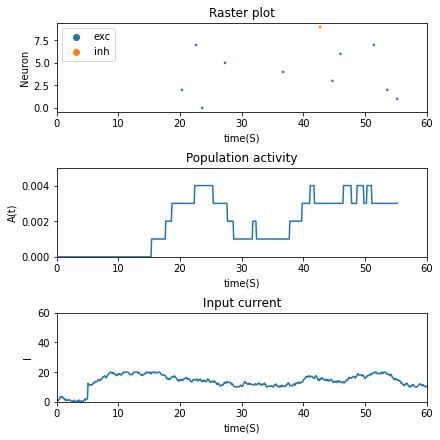

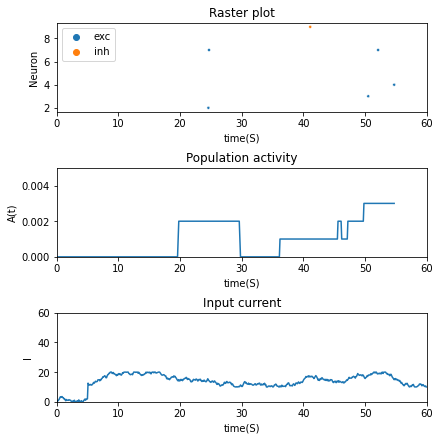

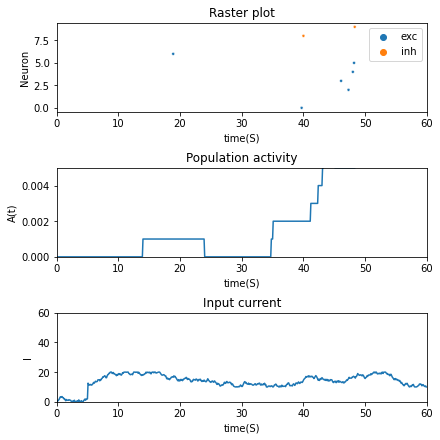

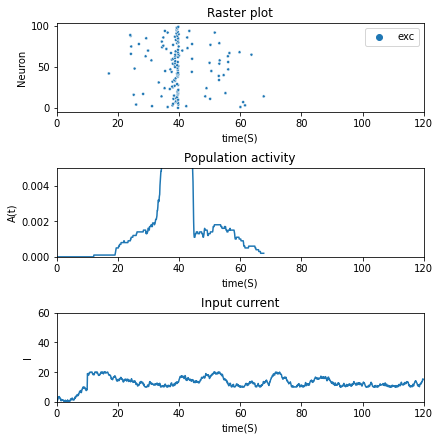

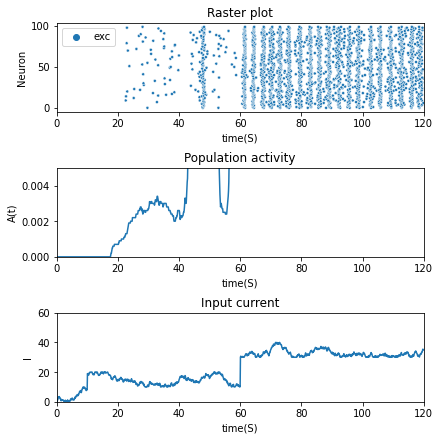

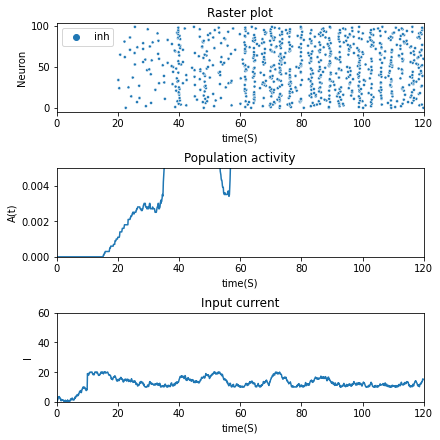

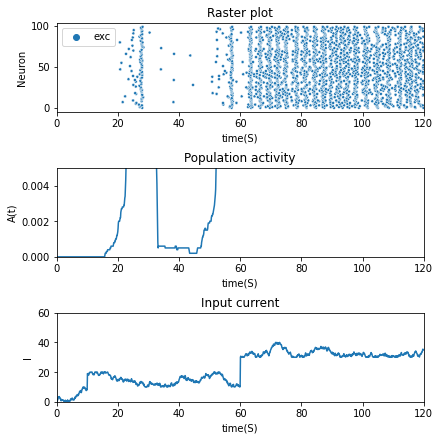

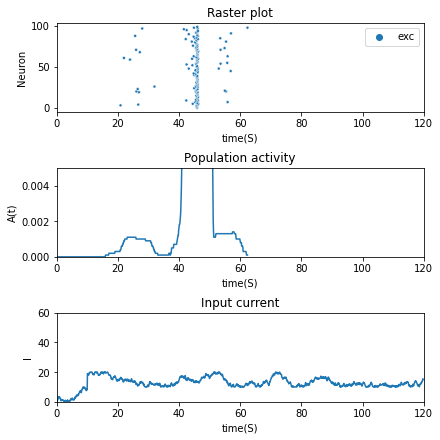

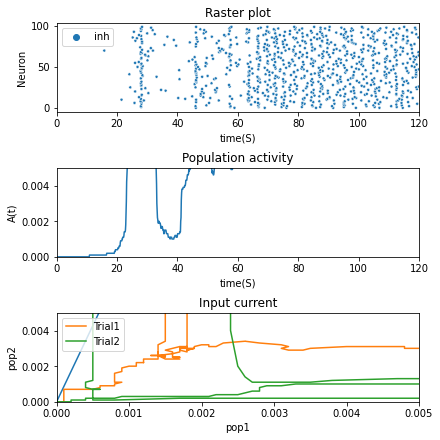

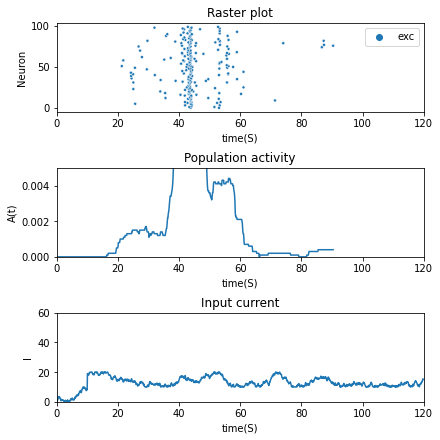

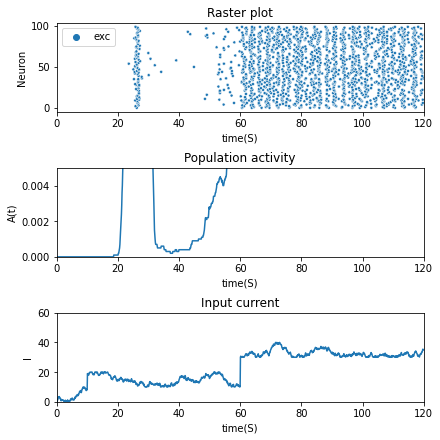

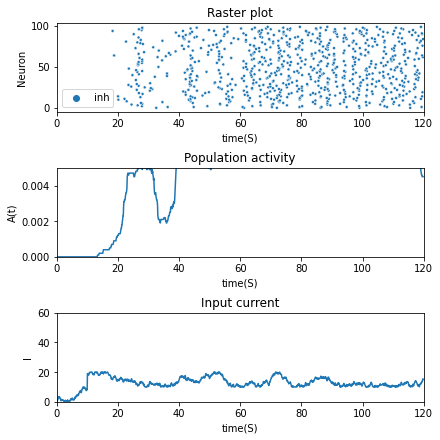

In [1]:
import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
dt = 0.1
class Neuron:
    def __init__(self, tau = 20, threshold = -50, u_rest = -65, R=1, is_exc = 1):
    
        self.u_rest = u_rest
        self.threshold = threshold 
        self.tau = tau
        self.R = R
        self.u = u_rest
        self.dt = dt
        self.is_exc = is_exc

        self.spike_history = list()
        self.post_synapses = list()
        self.u_input = 0
        
        
    def check_spike(self, time):
        if self.u >= self.threshold:
            self.u = self.u_rest
            self.spike_history.append(time)
            for synapse in self.post_synapses:
                post_neuron = synapse.post_neuron
                post_neuron.u_input+=synapse.w
            
        
        
    def next_tick(self, time, current_I):
        self.u += (-(self.u - self.u_rest) + self.R*current_I)*self.dt/self.tau + random.random()-.5
        self.check_spike(time)

                
    def reset_tick(self, time):
        self.u+=self.u_input
        self.u_input = 0
class Synapse:
    def __init__(self, pre_neuron, post_neuron, weight):
        self.pre_neuron = pre_neuron
        self.post_neuron = post_neuron
        self.w = weight
class PreFixedConnection:
    def __init__(self, pre_pop, post_pop, n_neighbors = 10):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.n_neighbors = n_neighbors
        self.make_connections(pre_pop, post_pop, n_neighbors)
    
    
    def make_connections(self, pre_pop, post_pop, n_neighbors):
        pre_neurons = pre_pop.neurons
        post_neurons = post_pop.neurons
        
        for post_neuron in post_neurons:
            for pre_neuron in np.random.choice( pre_neurons, n_neighbors, replace = False):
                self.add_synapse(pre_neuron, post_neuron)

                
    def add_synapse(self, pre_neuron, post_neuron):
        synapse = Synapse(pre_neuron, post_neuron, pre_neuron.is_exc*np.random.normal(0.45, 0.01))
        pre_neuron.post_synapses.append(synapse)
        
class FixedCouplingPConnection:
    def __init__(self, pre_pop, post_pop, J = 4.5, p = 0.01):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.J = J
        self.p = p
        self.make_connections(pre_pop, post_pop)
    
    def make_connections(self, pre_pop, post_pop):
        pre_neurons = pre_pop.neurons
        post_neurons = post_pop.neurons
        
        for post_neuron in post_neurons:
            for pre_neuron in pre_neurons:
                if np.random.random() < self.p:
                    weight = pre_neuron.is_exc*self.J/len(pre_neurons)/self.p +np.random.normal(0.0, 0.01)
                    self.add_synapse(pre_neuron, post_neuron, weight)

                
    def add_synapse(self, pre_neuron, post_neuron, weight):
        synapse = Synapse(pre_neuron, post_neuron, weight)
        pre_neuron.post_synapses.append(synapse)
        
class FullyConnected:
    def __init__(self, pre_pop, post_pop, J = 4.5):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.J = J

        self.make_connections(pre_pop, post_pop)
    
    def make_connections(self, pre_pop, post_pop):
        pre_neurons = pre_pop.neurons
        post_neurons = post_pop.neurons
        
        for post_neuron in post_neurons:
            for pre_neuron in pre_neurons:
                weight = pre_neuron.is_exc*self.J/len(pre_neurons) +np.random.normal(0.0, 0.001)
                self.add_synapse(pre_neuron, post_neuron, weight)

                
    def add_synapse(self, pre_neuron, post_neuron, weight):
        synapse = Synapse(pre_neuron, post_neuron, weight)
        pre_neuron.post_synapses.append(synapse)
        
class GaussianFullyConnected:
    def __init__(self, pre_pop, post_pop, J = 4.5, sigma = 1):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.J = J
        self.sigma = sigma

        self.make_connections(pre_pop, post_pop)
    
    def make_connections(self, pre_pop, post_pop):
        pre_neurons = pre_pop.neurons
        post_neurons = post_pop.neurons
        
        for post_neuron in post_neurons:
            for pre_neuron in pre_neurons:
                weight = pre_neuron.is_exc*np.random.normal(self.J/len(pre_neurons), self.sigma/len(pre_neurons))
                self.add_synapse(pre_neuron, post_neuron, weight)

                
    def add_synapse(self, pre_neuron, post_neuron, weight):
        synapse = Synapse(pre_neuron, post_neuron, weight)
        pre_neuron.post_synapses.append(synapse)
        
random_array = [10]
for i in range(36000):
    random_array.append(max(random_array[-1] +random.randint(-1, 1), 0))
def random_I(time):
    return random_array[int(time/dt)]
class Population:
    
    def __init__(self, size= 10, neuron= Neuron, exc_p = 0.8, I_gen = random_I):
        self.size = size
        self.neuron = neuron
        self.exc_p = exc_p
        self.neurons = list()
        
        self.I_gen = I_gen
        
        for i in range(int(size * exc_p)):
            self.neurons.append(neuron())
        for i in range(int(size * exc_p), size):
            self.neurons.append(neuron(is_exc = -1))
            
            
    def next_tick(self, time):
        for neuron in self.neurons:
            neuron.next_tick(time, self.I_gen(time))

            
    def reset_tick(self, time):
        for neuron in self.neurons:
            neuron.reset_tick(time)
            
    
    def get_spike_history(self):
        spike_history = []
        for idx, neuron in enumerate(self.neurons):
            for spike_time in neuron.spike_history:
                spike_history.append([idx , spike_time, neuron.is_exc])
        return spike_history
    def get_pop_activity(self, conv_size = 5 , full = True ):
        spike_times = np.array(np.array(self.get_spike_history())[:,1]/dt, dtype = int)
        pop_acitivity = np.bincount(spike_times)
        conv_size_norm = int(conv_size *(.1/dt))
        res = (np.convolve(pop_acitivity, conv_size_norm*[1/conv_size_norm], "same")/len(self.neurons))

        if full:
            return res
        else:
            return res[:-100]
        
class Model:
    def __init__(self):
        self.populations = []
        self.connections = []
        self.dt = dt
        
        
    def add_population(self, population):
        self.populations.append(population)
        
    
    def next_tick(self, time):
        for pop in self.populations:
            pop.next_tick(time)

            
    def reset_tick(self, time):
        for pop in self.populations:
            pop.reset_tick(time)
            
            
    def simulate(self, durations):
        for time in np.arange(0, durations, self.dt):
            self.next_tick(time)
            self.reset_tick(time)

            
    def get_spike_history(self):
        populations_spike_history = list()

        for pop in self.populations:
            populations_spike_history.append(pop.get_spike_history())
            
        return populations_spike_history
        

random_array = [0]
for i in range(36000):
    random_array.append(min(max(random_array[-1] +random.randint(-1, 1), 0), 25))
def plot_result(model, pop_num = 0):
    pop = model.populations[pop_num]
    spikes = np.array(model.get_spike_history()[pop_num])
    pop_act =pop.get_pop_activity(conv_size = 100)
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(3, 1)
    ax_s = fig.add_subplot(gs[0,0])
    ax_pa = fig.add_subplot(gs[1,0])
    ax_I = fig.add_subplot(gs[2,0])
    neuron_types = [ 'inh' if sign < 0 else 'exc' for sign in np.sign(spikes[:,2])]
    sns.scatterplot(y = spikes[:,0], x=spikes[:,1], hue = neuron_types, marker = '.', ax = ax_s)
    sns.lineplot(x = np.arange(0,duration,dt), y = [pop.I_gen(i) for i in np.arange(0,duration,dt)], ax = ax_I)
    sns.lineplot(x = np.arange(len(pop_act))*dt, y  = pop_act, ax = ax_pa)
    ax_s.set(xlim=(0, duration))
    ax_I.set(xlim=(0, duration))
    ax_pa.set(xlim=(0, duration))    
    ax_pa.set(ylim=(0, 0.005))
    ax_I.set(ylim=(0, 60))
    
    ax_s.set_title("Raster plot")
    ax_pa.set_title("Population activity")
    ax_I.set_title("Input current")
    
    ax_s.set(ylabel="Neuron", xlabel = "time(S)")
    ax_I.set(ylabel="I", xlabel = "time(S)")
    ax_pa.set(ylabel="A(t)", xlabel = "time(S)")

plt.rcParams['figure.figsize'] = (8, 8.0)       

#part2
random_array = [0]
for i in range(36000):
    random_array.append(min(max(random_array[-1] + 2*random.random()-1, 0), 10))
dt = 0.01
plt.rcParams['figure.figsize'] = (6, 6)

#part1 ex1
dt = 0.1
pop = Population(I_gen = lambda x:( random_I(x) +10*(x>5)))
connection = FullyConnected(pop, pop)
model = Model()
model.add_population(pop)
duration = 60
model.simulate(duration)

plot_result(model)

#part1 ex2
dt = 0.1
pop = Population(I_gen = lambda x:( random_I(x) +10*(x>5)))
connection = GaussianFullyConnected(pop, pop)
model = Model()
model.add_population(pop)
duration = 60
model.simulate(duration)

plot_result(model)

#part1 ex3
dt = 0.1
pop = Population(I_gen = lambda x:( random_I(x) +10*(x>5)))
connection = FixedCouplingPConnection(pop, pop)
model = Model()
model.add_population(pop)
duration = 60
model.simulate(duration)

plot_result(model)

#part1 ex4
dt = 0.1

pop = Population(I_gen = lambda x:( random_I(x) +10*(x>5)))
connection = PreFixedConnection(pop, pop, n_neighbors=10)
model = Model()
model.add_population(pop)
duration = 60
model.simulate(duration)

plot_result(model)

#part2 ex1
base_I = 10
decision_I = 20
exc_pop1 = Population(size = 100 , exc_p = 1, I_gen =  lambda x:random_I(x)+base_I*(x>10))
exc_pop2 = Population(size = 100 , exc_p = 1, I_gen = lambda x:( random_I(x)+base_I*(x>10)+decision_I*(x>60)))
inh_pop = Population(size = 100, exc_p = 0, I_gen = lambda x:random_I(x)+base_I*(x>10))

connection = PreFixedConnection(exc_pop1, exc_pop1, n_neighbors=30)
connection = PreFixedConnection(exc_pop2, exc_pop2, n_neighbors=30)

connection = PreFixedConnection(exc_pop2, inh_pop, n_neighbors=10)
connection = PreFixedConnection(inh_pop, exc_pop2, n_neighbors=10)
connection = PreFixedConnection(inh_pop, exc_pop1, n_neighbors=10)
connection = PreFixedConnection(exc_pop1, inh_pop, n_neighbors=10)

model = Model()
model.add_population(exc_pop1)
model.add_population(exc_pop2)
model.add_population(inh_pop)
duration = 120
model.simulate(duration)
plot_result(model, 0)
plot_result(model, 1)
plot_result(model, 2)
pop_act1, pop_act2 = exc_pop1.get_pop_activity(conv_size = 100, full= False), exc_pop2.get_pop_activity(conv_size = 100, full= False)

#part2 ex2
base_I = 10
decision_I = 20
exc_pop1 = Population(size = 100 , exc_p = 1, I_gen =  lambda x:random_I(x)+base_I*(x>10)+decision_I*(x>60))
exc_pop2 = Population(size = 100 , exc_p = 1, I_gen = lambda x:random_I(x)+base_I*(x>10))
inh_pop = Population(size = 100, exc_p = 0, I_gen = lambda x:random_I(x)+base_I*(x>10))

connection = PreFixedConnection(exc_pop1, exc_pop1, n_neighbors=30)
connection = PreFixedConnection(exc_pop2, exc_pop2, n_neighbors=30)

connection = PreFixedConnection(exc_pop2, inh_pop, n_neighbors=10)
connection = PreFixedConnection(inh_pop, exc_pop2, n_neighbors=10)
connection = PreFixedConnection(inh_pop, exc_pop1, n_neighbors=10)
connection = PreFixedConnection(exc_pop1, inh_pop, n_neighbors=10)

model = Model()
model.add_population(exc_pop1)
model.add_population(exc_pop2)
model.add_population(inh_pop)
duration = 120
model.simulate(duration)
plot_result(model, 0)
plot_result(model, 1)
plot_result(model, 2)


#part3
import numpy as np

ax_scatter = plt.gca()
ax_scatter.set(xlim=(0, 0.005), ylim=(0, .005))

pa_size2 =min(len(pop_act1), len(pop_act2))
trial1 = np.zeros((pa_size2,2))
trial1[:,0] = pop_act1[:pa_size2]
trial1[:,1] = pop_act2[:pa_size2]

pa_size = min(len(exc_pop1.get_pop_activity(conv_size = 100, full = False)), 
              len(exc_pop2.get_pop_activity(conv_size = 100, full = False)))
trial2 = np.zeros((pa_size,2))
trial2[:,0] = exc_pop1.get_pop_activity(conv_size = 100, full = False)[:pa_size]
trial2[:,1] = exc_pop2.get_pop_activity(conv_size = 100,  full = False)[:pa_size]

plt.plot(*trial1.T, label = 'Trial1')
plt.plot(*trial2.T, label = 'Trial2')
plt.ylabel('pop2')
plt.xlabel('pop1')
plt.legend()
plt.show()

#example
base_I = 10
decision_I = 20
exc_pop1 = Population(size = 100 , exc_p = 1, I_gen =  lambda x:random_I(x)+base_I*(x>10))
exc_pop2 = Population(size = 100 , exc_p = 1, I_gen = lambda x:( random_I(x)+base_I*(x>10)+decision_I*(x>60)))
inh_pop = Population(size = 100, exc_p = 0, I_gen = lambda x:random_I(x)+base_I*(x>10))

connection = FixedCouplingPConnection(exc_pop1, exc_pop1, J=13.5, p=0.1)
connection = FixedCouplingPConnection(exc_pop2, exc_pop2, J=13.5, p=0.1)

connection = FixedCouplingPConnection(exc_pop2, inh_pop, J=4.5, p=0.1)
connection = FixedCouplingPConnection(inh_pop, exc_pop2, J=4.5, p=0.1)
connection = FixedCouplingPConnection(inh_pop, exc_pop1, J=4.5, p=0.1)
connection = FixedCouplingPConnection(exc_pop1, inh_pop, J=4.5, p=0.1)

model = Model()
model.add_population(exc_pop1)
model.add_population(exc_pop2)
model.add_population(inh_pop)
duration = 120
model.simulate(duration)
plot_result(model, 0)
plot_result(model, 1)
plot_result(model, 2)
pop_act1, pop_act2 = exc_pop1.get_pop_activity(conv_size = 100, full= False), exc_pop2.get_pop_activity(conv_size = 100, full= False)
